In [1]:
# importing all the required libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import scipy.stats
import matplotlib.dates as mdates
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [10, 5]
import random
import geopandas
from shapely.geometry import Point

import io
import requests
import json
from bs4 import BeautifulSoup
from lxml import html

import time

In [2]:
# functions to extract the data from online
# Add a functionality that if data already exists in the directory then it shouldn't be downloaded again

def extract_url(raw_url, query, months, limit):
    
    url_content = []
    for month in months:
        url = raw_url+query+" AND date_extract_m(tpep_pickup_datetime) = "+str(month)+" LIMIT "+str(limit)
        r = requests.get(url)  #total rows = 131165043
        url_content.append(r.content)
    return url_content

def generate_df(raw_url, query, months, limit = 100, date_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime'], 
                cols_to_use = 'default'):
    
    if cols_to_use == 'default':
        cols = ['vendorid', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
               'passenger_count', 'trip_distance', 'pickup_longitude',
               'pickup_latitude', 'store_and_fwd_flag',
               'dropoff_longitude', 'dropoff_latitude', 'pulocationid', 'dolocationid']
    else:
        cols = cols_to_use
        
    df_dict = {}
    url_content = extract_url(raw_url, query, months, limit = limit)
    for i,j in enumerate(url_content):
        df_dict['month_'+str(i+1)] = pd.read_csv(io.StringIO(url_content[i].decode('utf-8')), 
                usecols = cols, parse_dates = date_cols)
    df = pd.concat(df_dict, axis='rows', ignore_index=True)
    df = df.rename(columns={'tpep_pickup_datetime': "pickup_datetime", 
                                          'tpep_dropoff_datetime': "dropoff_datetime"})
    return df


Below is the url API to access the data from city of new york's website and we can filter the data using the query. More information on how to extract the data from city of new york's site can be found [here](https://dev.socrata.com/foundry/data.cityofnewyork.us/uacg-pexx)

In [3]:
raw_url = "https://data.cityofnewyork.us/resource/uacg-pexx.csv?"
query = "$query= SELECT * WHERE pickup_longitude IS NOT NULL AND pickup_latitude IS NOT NULL" 

Limit is the number of rows that will be extracted randomly from each month.
Let's extract 700000 trip records from each month from January to June of 2016. Extracting the 1st 6 months only because 
only the first 6 months have the exact pickup and dropoff lat lon locations.   
_Note_ : We can even pass 1 to 12, because our query anyways will filter out the data where pickup_longitude and pickup_latitude is not NULL but filtering all 12 months will take more time.

In [4]:
## Add a code here such that the below generate_df will run only if the .csv file (saved later) is already not available 
#...in the data directory 
t0 = time.time()
nyc_sql = generate_df(raw_url, query, months = range(1,7), limit = 700000)
print('time to load dataset: ', time.time() - t0)

time to load dataset:  282.50183725357056


In [5]:
nyc_sql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200000 entries, 0 to 4199999
Data columns (total 12 columns):
vendorid              int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count       int64
trip_distance         float64
pickup_longitude      float64
pickup_latitude       float64
store_and_fwd_flag    object
dropoff_longitude     float64
dropoff_latitude      float64
pulocationid          float64
dolocationid          float64
dtypes: datetime64[ns](2), float64(7), int64(2), object(1)
memory usage: 384.5+ MB


In [6]:
nyc_sql['pickup_datetime'].min(), nyc_sql['pickup_datetime'].max()

(Timestamp('2016-01-01 00:00:08'), Timestamp('2016-06-30 23:59:58'))

In [7]:
nyc_sql['pickup_datetime'].dt.day.sort_values().value_counts()

16    146048
14    144536
5     143671
19    143268
12    143072
15    142949
9     142648
6     142476
13    142367
17    141630
11    141457
4     141347
20    141138
10    140962
8     140349
21    140134
7     139298
3     138759
18    138694
2     137907
22    137546
26    135936
27    135915
1     134477
29    134265
25    133708
28    131980
24    125426
23    119184
30    112639
31     66214
Name: pickup_datetime, dtype: int64

In [8]:
nyc_sql['dropoff_datetime'].dt.day.sort_values().value_counts()

16    145812
14    144325
5     143666
19    143124
12    143033
15    142960
9     142554
13    142520
6     142509
17    141892
11    141272
10    141254
20    141169
4     141121
21    140276
8     140264
7     139413
3     139083
18    138747
22    137565
2     137449
26    136034
27    136028
1     134724
29    134050
25    133376
28    132125
24    125352
23    119370
30    112513
31     66420
Name: dropoff_datetime, dtype: int64

In [13]:
# WE are going to remove this 'trip_distance' column because it is strongly associated with our dependent variable trip_duration
#...and using that for prediction will mean allowing data leakage
# But checking the stats on the variable before removing it

percentile_trip_distance = [25, 50, 75, 95, 99, 99.8]
print("Total number of trips = {:,}".format(len(nyc_sql)))
for i in percentile_trip_distance:
    print("{}% of the trips were below {:.2f} miles".format(i, np.percentile(nyc_sql.trip_distance, i)))

Total number of trips = 4,200,000
25% of the trips were below 1.00 miles
50% of the trips were below 1.70 miles
75% of the trips were below 3.17 miles
95% of the trips were below 10.52 miles
99% of the trips were below 18.66 miles
99.8% of the trips were below 22.05 miles


In [14]:
nyc_sql.describe().T

,count,mean,std,min,25%,50%,75%,max
vendorid,4200000.0,1.530776,0.499052,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,4200000.0,1.661372,1.310862,0.000000,1.000000,1.000000,2.000000,9.000000e+00
trip_distance,4200000.0,4.963236,2770.393796,0.000000,1.000000,1.700000,3.170000,5.361520e+06
pickup_longitude,4200000.0,-72.920719,8.762610,-131.818970,-73.991699,-73.981461,-73.966309,0.000000e+00
pickup_latitude,4200000.0,40.170876,4.827042,0.000000,40.736206,40.753475,40.768158,5.124434e+01
dropoff_longitude,4200000.0,-72.983583,8.500235,-121.933372,-73.991203,-73.979462,-73.962013,0.000000e+00
dropoff_latitude,4200000.0,40.206430,4.682630,0.000000,40.734600,40.753967,40.769550,4.918594e+01
pulocationid,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dolocationid,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
nyc_sql.to_csv('../data/raw/nyc_2016_raw_sql.csv')

In [12]:
stop here

SyntaxError: invalid syntax (<ipython-input-12-a96ba3aab008>, line 1)

#### Preparing the data for more EDA and adding new features

In [ ]:
# Importing data preparation modules
import sys
sys.path.append('../NYC')

In [ ]:
#%load_ext autoreload
import data_prep
import importlib
importlib.reload(data_prep)
print(dir(data_prep))

In [ ]:
## Add a code here such that the below prepare_dataframe will run only if the .csv file (saved later) is already not available 
#...in the data directory 
import warnings
warnings.filterwarnings('ignore')
nyc_raw = data_prep.prepare_dataframe(raw_df = nyc_sql)

In [ ]:
print("Fraction of data omitted  = {:.2f} %".format(1- len(nyc_raw)/len(nyc_sql)))

In [ ]:
nyc_raw.head(3)

In [ ]:
# saving data to interim datasets
nyc_raw.to_csv('../data/interim/nyc_raw_cony.csv')

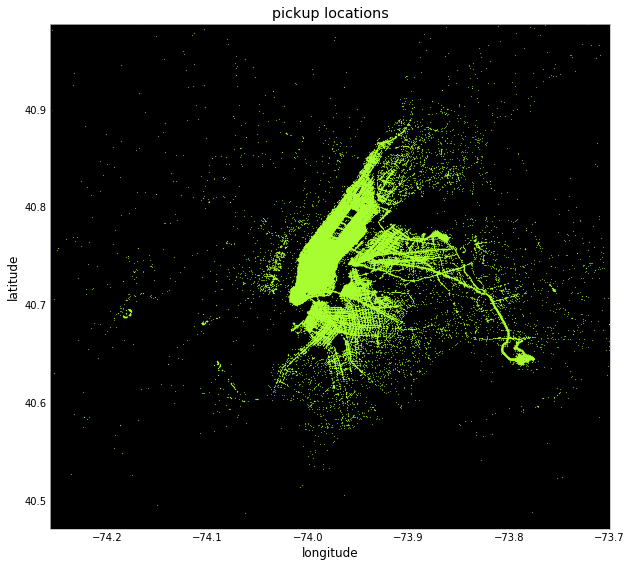

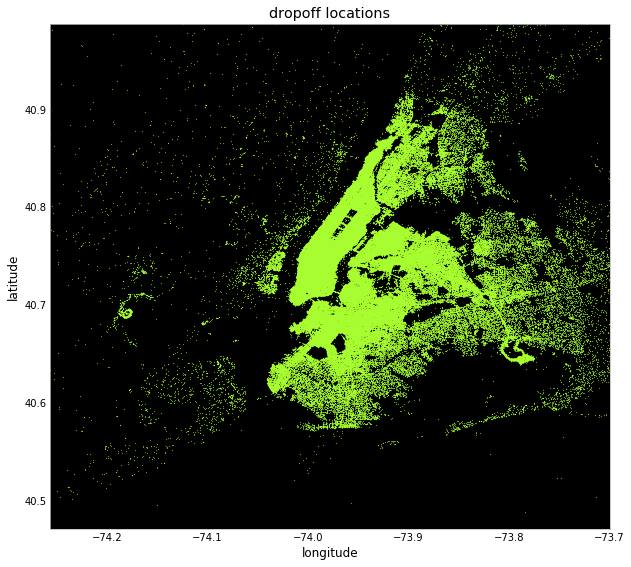

In [15]:
# PLotting the lat and lon of the pickup locations to get a gist of the data
def plot_points(df = nyc_sql, colA = 'pickup_longitude', colB = 'pickup_latitude', s = 0.5, alpha = 0.5, 
                color_points = 'xkcd:lime', color_background = 'xkcd:black', figsize = (7,7),
                nyc_long_limits = (-74.257159, -73.699215), nyc_lat_limits = (40.471021, 40.987326)):
   
    nyc_long_limits = nyc_long_limits
    nyc_lat_limits = nyc_lat_limits
    figsize = (abs(nyc_long_limits[0] - nyc_long_limits[1])*figsize[0], 
                            abs(nyc_lat_limits[0] - nyc_lat_limits[1])*figsize[1])
    
    fig, ax = plt.subplots(1, figsize = figsize)
    _ = ax.scatter(df[colA].values, df[colB].values,
                  color = color_points, s = s, label='train', alpha = alpha)
    
    _ = ax.set_ylabel('latitude')
    _ = ax.set_xlabel('longitude')
    
    _ = plt.ylim(nyc_lat_limits)
    _ = plt.xlim(nyc_long_limits)
    _ = plt.title(colA.replace("_", " ").split(" ")[0] + ' locations')
    
    _ = ax.set_facecolor(color_background)
    _ = ax.grid(False)    #= plt.grid(b=None)
    
    
plot_points(df = nyc_sql, colA = 'pickup_longitude', colB = 'pickup_latitude', figsize = (18, 18))
plot_points(df = nyc_sql, colA = 'dropoff_longitude', colB = 'dropoff_latitude', figsize = (18, 18))

In [16]:
percentile_trip_duration = [1, 25, 50, 75, 95, 99, 99.8]
print("Total number of trips = {:,}".format(len(nyc_sql)))
for i in percentile_trip_duration:
    print("{}% of the trips were below {:.2f} minutes".format(i, np.percentile(nyc_sql.trip_duration/60, i)))

Total number of trips = 4,200,000


AttributeError: 'DataFrame' object has no attribute 'trip_duration'

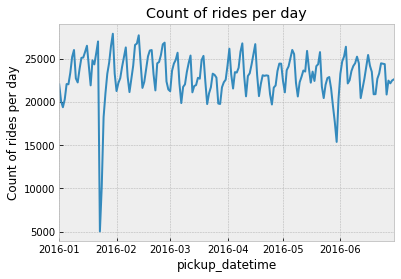

In [17]:
# Checking number of trips by day
_ = nyc_sql.groupby(nyc_sql.pickup_datetime.dt.date).size().plot()
_ = plt.title('Count of rides per day')
_ = plt.ylabel('Count of rides per day')

KeyError: 'Column not found: trip_duration'

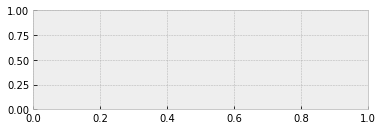

In [18]:
# Plotting average trip duration for each hour over the entire year
ax1 = plt.subplot(211)
_ = nyc_sql.groupby(nyc_sql.pickup_datetime.dt.hour)['trip_duration'].mean().plot(ax = ax1, figsize=(10,6))
_ = plt.ylabel('Trip duration in seconds')
_ = plt.xticks(nyc_sql.pickup_datetime.dt.hour.unique())
_ = plt.title('Trip duration in seconds averaged over hours in the year of 2016')

# Plotting the average number of rides per hour
ax2 = plt.subplot(212)
_ = nyc_sql.groupby([nyc_sql.pickup_datetime.dt.date, 
                    nyc_sql.pickup_datetime.dt.hour]).count().groupby(nyc_sql.pickup_datetime.dt.hour).mean().plot(ax = ax2, 
                                                                                                            figsize=(10,6))
_ = plt.ylabel('Average count of pickups per hour')
_ = plt.xticks(nyc_sql.pickup_datetime.dt.hour.unique())
_ = plt.title('Average count of pickups per hour in the year of 2016')
_ = plt.tight_layout()

#### Plotting a heatmap with a colorbar; the colorbar shows the trip duration in seconds

In [ ]:

hour_weekday = nyc_raw.pivot_table(values = 'trip_duration', index = 'pickup_hour', 
                                   columns = 'pickup_weekday', aggfunc = 'mean')
_ = plt.figure(figsize=(15, 8))
ax = sns.heatmap(hour_weekday.sort_index(ascending = False), cmap='viridis', cbar_kws={'label': 'trip duration seconds'})
_ = ax.set_title("Average trip duration in seconds for each hour of each weekday averaged over 2016", fontsize = 14)

In [ ]:
tune in for more fun

In [ ]:
import pyproj
pyproj.__version__

In [ ]:
import bokeh, bokeh.plotting, bokeh.models
from bokeh.io import output_notebook, show
output_notebook()

import geopandas as gpd
from shapely.geometry import Point
import urllib
import dask.dataframe as dd
import dask.distributed
import numpy as np

import sklearn.preprocessing

client = dask.distributed.Client()



In [ ]:
coord_system = {'init': 'epsg:4326'}
df = gpd.read_file('../data/external/taxi_zones_shape/taxi_zones.shp').to_crs(coord_system)
df = df.drop(['Shape_Area', 'Shape_Leng', 'OBJECTID'], axis=1)
df.head()

In [ ]:
gjds = bokeh.models.GeoJSONDataSource(geojson=df.to_json())
TOOLS = "pan,wheel_zoom,reset,hover,save"

p = bokeh.plotting.figure(title="NYC Taxi Districts", tools=TOOLS,
    x_axis_location=None, y_axis_location=None)

color_mapper = bokeh.models.LinearColorMapper(palette=bokeh.palettes.Viridis256)

p.patches('xs', 'ys', 
          fill_color={'field': 'LocationID', 'transform': color_mapper},
          fill_alpha=1., line_color="black", line_width=0.5,          
          source=gjds)

p.grid.grid_line_color = None

hover = p.select_one(bokeh.models.HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = u"""
<div> 
    <div class="bokeh_hover_tooltip">Name : @zone</div>
    <div class="bokeh_hover_tooltip">Borough : @borough</div>
    <div class="bokeh_hover_tooltip">Zone ID : @LocationID</div>
    <div class="bokeh_hover_tooltip">(Lon, Lat) : ($x ˚E, $y ˚N)</div>
</div>
"""

#p.circle([-73.966,], [40.78,], size=10, fill_color='magenta', line_color='yellow', line_width=1, alpha=1.0)

show(p)

In [ ]:
df2 = df.copy()
df2['geometry'] = df.geometry.envelope
df2['borough_categ'] = sklearn.preprocessing.LabelEncoder().fit_transform(df2['borough'])
gjds2 = bokeh.models.GeoJSONDataSource(geojson=df2.to_json())

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = bokeh.plotting.figure(title="NYC Taxi Districts Bounding Boxes", tools=TOOLS,
    x_axis_location=None, y_axis_location=None)

color_mapper = bokeh.models.LinearColorMapper(palette=bokeh.palettes.Viridis256)

p.patches('xs', 'ys', 
          fill_color={'field': 'borough_categ', 'transform': color_mapper},
          fill_alpha=0.7, line_color="black", line_width=0.5,          
          source=gjds2)

p.grid.grid_line_color = None

hover = p.select_one(bokeh.models.HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = u"""
<div> 
    <div class="bokeh_hover_tooltip">Name : @zone</div>
    <div class="bokeh_hover_tooltip">Borough : @borough</div>
    <div class="bokeh_hover_tooltip">Zone ID : @LocationID</div>
    <div class="bokeh_hover_tooltip">(Lon, Lat) : ($x ˚E, $y ˚N)</div>
</div>
"""

p.circle([-73.966,], [40.78,], size=10, fill_color='magenta', line_color='yellow', line_width=1, alpha=1.0)

show(p)

In [ ]:
gpd.sjoin(gpd.GeoDataFrame(crs={'init': 'epsg:4326'}, geometry=[Point(-73.966, 40.78)]), 
          df,
          how='left', op='within')

In [ ]:
client = dask.distributed.Client()

In [ ]:
nyc_trips = dd.read_csv('../data/processed/nyc_data.csv')
print("There are {} partitions. ".format(nyc_trips.npartitions))
nyc_trips[('pickup_datetime pickup_longitude'
        ' pickup_latitude').split()].head()

In [ ]:
nyc_trips[('dropoff_datetime dropoff_longitude'
        ' dropoff_latitude').split()].head()

In [ ]:
x, y = (nyc_trips[('pickup_datetime pickup_longitude'
        ' pickup_latitude').split()].head()).iloc[0, 1:3]
x2, y2 = (nyc_trips[('dropoff_datetime dropoff_longitude'
        ' dropoff_latitude').split()].head()).iloc[0, 1:3]

In [ ]:
gpd.sjoin(gpd.GeoDataFrame(crs={'init': 'epsg:4326'}, 
                           geometry=[Point(x, y), Point(x2, y2)]), 
                           df,
                           how='left', op='within')

In [ ]:
def assign_taxi_zones(df, lon_var, lat_var, locid_var):
    
    # make a copy since we will modify lats and lons
    localdf = df[[lon_var, lat_var]].copy()
    
    # missing lat lon info is indicated by nan. Fill with zero
    # which is outside New York shapefile. 
    localdf[lon_var] = localdf[lon_var].fillna(value=0.)
    localdf[lat_var] = localdf[lat_var].fillna(value=0.)
    

    shape_df = gpd.read_file('../data/external/taxi_zones_shape/taxi_zones.shp')
    shape_df.drop(['OBJECTID', "Shape_Area", "Shape_Leng", "borough", "zone"],
                  axis=1, inplace=True)
    shape_df = shape_df.to_crs({'init': 'epsg:4326'})

    try:
        local_gdf = gpd.GeoDataFrame(
            localdf, crs={'init': 'epsg:4326'},
            geometry=[Point(xy) for xy in
                      zip(localdf[lon_var], localdf[lat_var])])

        local_gdf = gpd.sjoin(
            local_gdf, shape_df, how='left', op='within')

        return local_gdf.LocationID.rename(locid_var)
    except ValueError as ve:
        print(ve)
        print(ve.stacktrace())
        series = localdf[lon_var]
        series = np.nan
        return series

In [ ]:
# mapping pickup locations
nyc_trips['pickup_taxizone_id'] = nyc_trips.map_partitions(
    assign_taxi_zones, "pickup_longitude", "pickup_latitude",
    "pickup_taxizone_id", meta=('pickup_taxizone_id', np.float64))

# mapping dropoff locations
nyc_trips['dropoff_taxizone_id'] = nyc_trips.map_partitions(
    assign_taxi_zones, "dropoff_longitude", "dropoff_latitude",
    "dropoff_taxizone_id", meta=('dropoff_taxizone_id', np.float64))


In [ ]:
nyc_trips[['pickup_taxizone_id', 'dropoff_taxizone_id']].head()

In [ ]:
nyc_trips.to_parquet('../data/interim/nyc_data_2016.parquet', has_nulls = True, object_encoding = 'json', 
                     compression = "GZIP")

In [ ]:
trips = dd.read_parquet('../data/interim/nyc_data_2016.parquet', 
                        columns = ['pickup_taxizone_id', 'dropoff_taxizone_id'])

In [ ]:
counts = trips.groupby('dropoff_taxizone_id').count().compute()
counts.columns = ['N']
counts2 = df.merge(counts, left_on='LocationID', right_index=True, how='left')

gjds = bokeh.models.GeoJSONDataSource(geojson=counts2.to_json())
TOOLS = "pan,wheel_zoom,reset,hover,save"

p = bokeh.plotting.figure(title="NYC Taxi Dropoffs Heatmap", tools=TOOLS,
    x_axis_location=None, y_axis_location=None)

color_mapper = bokeh.models.LogColorMapper(palette=bokeh.palettes.Viridis256, low=1, high=100000)

p.patches('xs', 'ys', 
          fill_color={'field': 'N', 'transform': color_mapper},
          fill_alpha=1., line_color="black", line_width=0.5,          
          source=gjds)

p.grid.grid_line_color = None

hover = p.select_one(bokeh.models.HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = u"""
<div> 
    <div class="bokeh_hover_tooltip">Name : @zone</div>
    <div class="bokeh_hover_tooltip">Borough : @borough</div>
    <div class="bokeh_hover_tooltip">Trips Start : @N</div>
</div>
"""

color_bar = bokeh.models.ColorBar(
    color_mapper=color_mapper, orientation='horizontal',
    ticker=bokeh.models.FixedTicker(ticks=[3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000]),
    formatter=bokeh.models.PrintfTickFormatter(format='%d'),
    label_standoff=12, border_line_color=None, location=(0,0))
p.add_layout(color_bar, 'below')

show(p)

In [ ]:
nyc = nyc_trips.compute()

In [ ]:
nyc.head()

In [ ]:
#nyc.info()

In [ ]:
nyc.to_csv('../data/interim/nyc_with_zones.csv')

In [ ]:
nyc.pickup_taxizone_id.nunique(), nyc.dropoff_taxizone_id.nunique()

In [ ]:
nyc.pickup_taxizone_id.isna().sum(), nyc.dropoff_taxizone_id.isna().sum()

In [ ]:
nyc = nyc[(pd.notnull(nyc.pickup_taxizone_id)) & (pd.notnull(nyc.dropoff_taxizone_id))]

In [ ]:
#nyc.info()

In [ ]:
#nyc.isna().sum()

In [ ]:
p_d = nyc.groupby(['pickup_taxizone_id', 'dropoff_taxizone_id']).trip_duration_minutes.count()

In [ ]:
p_d[p_d >= 2]

In [ ]:
p_d_time = nyc.groupby(['pickup_taxizone_id', 'dropoff_taxizone_id']).trip_duration_minutes.mean()

In [ ]:
p_d_time.reset_index()

In [ ]:
p_d_time_pivot = p_d_time.reset_index().pivot_table(values = 'trip_duration_minutes', index = 'pickup_taxizone_id', 
                                     columns = 'dropoff_taxizone_id', aggfunc = 'mean')

In [ ]:
_ = plt.figure(figsize=(15, 8)) #gist_rainbow
ax = sns.heatmap(p_d_time_pivot.sort_index(ascending = False), cmap='gist_rainbow', 
                 cbar_kws={'label': 'Average trip_duration_minutes'})
_ = ax.set_title("Average trip duration in minutes for each pair of taxi zones", fontsize = 14)